## objective: 
### To detect structural query language (SQL) injection attacks based on deep learning approaches; CNN autoencoder, SMOTE, LSTM and compare its perfomance within conventional ML.

# import required libraries

In [55]:
#GPU check
import tensorflow as tf
# Set memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [56]:
tf.__version__

'2.10.1'

In [57]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [58]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [67]:
#import required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

from tensorflow.python.framework import ops

warnings.filterwarnings('ignore')

# Reading data

In [60]:
# reading Modified_SQL_Dataset from hard drive
df=pd.read_csv('Modified_SQL_Dataset.csv')
df.head(10)

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
5,select name from syscolumns where id = ...,1
6,select * from users where id = 1 +$+ or 1 =...,1
7,"1; ( load_file ( char ( 47,101,116,99,47...",1
8,select * from users where id = '1' or ||/1 ...,1
9,select * from users where id = '1' or \.<\ ...,1


In [61]:
#displaying data information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


# Drop duplicated rows and keep only unique ones

In [62]:
# Drop duplicated rows and keep only unique ones
unique_df = df.drop_duplicates()

In [63]:
unique_df.shape

(30907, 2)

In [64]:
unique_df.head(10)

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
5,select name from syscolumns where id = ...,1
6,select * from users where id = 1 +$+ or 1 =...,1
7,"1; ( load_file ( char ( 47,101,116,99,47...",1
8,select * from users where id = '1' or ||/1 ...,1
9,select * from users where id = '1' or \.<\ ...,1


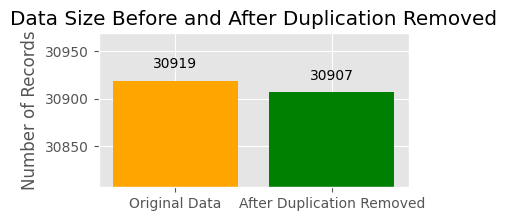

In [68]:
import matplotlib.pyplot as plt

# Data for plotting
original_data = 30919
after_duplication_removed = 30907

# Labels for the bar chart
labels = ['Original Data', 'After Duplication Removed']
values = [original_data, after_duplication_removed]

# Create bar chart
plt.figure(figsize=(4, 2))
bars = plt.bar(labels, values, color=['orange', 'green'])

# Add data count at the top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, ha='center', va='bottom')

# Set title and labels
plt.title('Data Size Before and After Duplication Removed')
plt.ylabel('Number of Records')

# Adjust the y-axis limit to make the difference more visible
plt.ylim(min(values) - 100, max(values) + 50)

# Save the plot as an image
plt.savefig('duplication_removed.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


# lets count total class 0 and 1
 ### 0: for normal 
 ### 1: for malicious

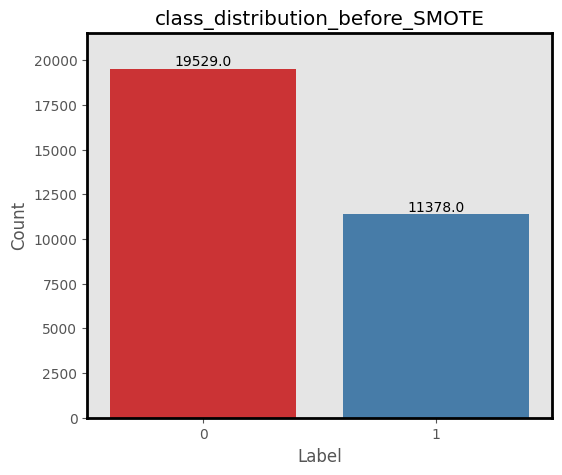

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the countplot with vertical bars
plt.figure(figsize=(6, 5))
plt.rcParams["axes.grid"] = False

# Swap y with x to make the bars vertical
ax = sns.countplot(x=unique_df['Label'], palette='Set1')

# Add count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.1), 
                ha='center', va='bottom')

# Adjust labels and title
plt.title('class_distribution_before_SMOTE')
plt.xlabel('Label')
plt.ylabel('Count')

# Adjust y-axis limit to give space for annotations
ax.set_ylim(0, ax.get_ylim()[1] * 1.05)

# Make border (axes spines) bold
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set border (spine) line width
    spine.set_edgecolor('black')  # Set border (spine) line color

# Save and show the plot
save_path = 'class_distribution_before_SMOTE.png'
plt.savefig(save_path)
plt.show()

# lets separete features and targets

# balancing dataset

In [18]:
#split label and features
X = unique_df['Query']
y = unique_df['Label']

vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

# Convert the resampled data back into a DataFrame for easy handling
resampled_dataset = pd.DataFrame(X_resampled.toarray(), columns=vectorizer.get_feature_names_out())
resampled_dataset['Label'] = y_resampled

# Check the distribution of the resampled labels
print(resampled_dataset['Label'].value_counts())

#Split the Dataset
X_temp, X_test, y_temp, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

X_train_tfidf = np.reshape(X_train.toarray(), (X_train.shape[0], 1, X_train.shape[1]))
X_val_tfidf = np.reshape(X_val.toarray(), (X_val.shape[0], 1, X_val.shape[1]))
X_test_tfidf = np.reshape(X_test.toarray(), (X_test.shape[0], 1, X_test.shape[1]))

tf.compat.v1.disable_eager_execution()

Label
1    19529
0    19529
Name: count, dtype: int64


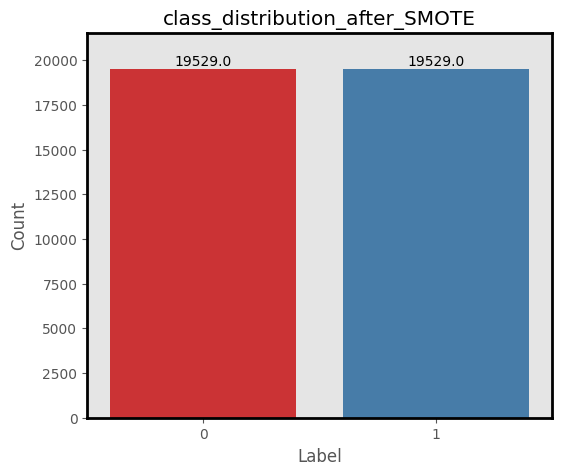

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the countplot with vertical bars
plt.figure(figsize=(6, 5))
plt.rcParams["axes.grid"] = False

# Swap y with x to make the bars vertical
ax = sns.countplot(x=resampled_dataset['Label'], palette='Set1')

# Add count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.1), 
                ha='center', va='bottom')

# Adjust labels and title
plt.title('class_distribution_after_SMOTE')
plt.xlabel('Label')
plt.ylabel('Count')

# Adjust y-axis limit to give space for annotations
ax.set_ylim(0, ax.get_ylim()[1] * 1.05)

# Make border (axes spines) bold
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set border (spine) line width
    spine.set_edgecolor('black')  # Set border (spine) line color

# Save and show the plot
save_path = 'class_distribution_after_SMOTE.png'
plt.savefig(save_path)
plt.show()

# developing the proposed

## Bulid RNN Autoencoder

In [25]:
# Assuming X_train_tfidf is initially 2D with shape (num_samples, features)
timesteps = 1  # Set this based on data or desired sequence length
features = X_train_tfidf.shape[-1]

# Reshape your data to include the timesteps dimension
X_train_tfidf = X_train_tfidf.reshape(-1, timesteps, features)
X_val_tfidf = X_val_tfidf.reshape(-1, timesteps, features)
X_test_tfidf = X_test_tfidf.reshape(-1, timesteps, features)

# Build the RNN Autoencoder
input_shape = (timesteps, features)
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(features, activation='sigmoid'))
decoder_outputs = decoder_dense(decoder_outputs)

autoencoder_model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="SQLI_Attack_Detecter")
autoencoder_model.compile(optimizer='adam', loss='mse')
autoencoder_model.summary()

# Train the Autoencoder
autenHistory = autoencoder_model.fit([X_train_tfidf, X_train_tfidf], X_train_tfidf, epochs=10, batch_size=8, validation_data=([X_val_tfidf, X_val_tfidf], X_val_tfidf))

Model: "SQLI_Attack_Detecter"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 24733)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 24733)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 1, 64),      6348288     ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                               

In [26]:
# Evaluate the Model
loss = autoencoder_model.evaluate([X_test_tfidf, X_test_tfidf], X_test_tfidf)
print("Encoding Test Loss:", loss) 

Encoding Test Loss: 0.0004923028739205481


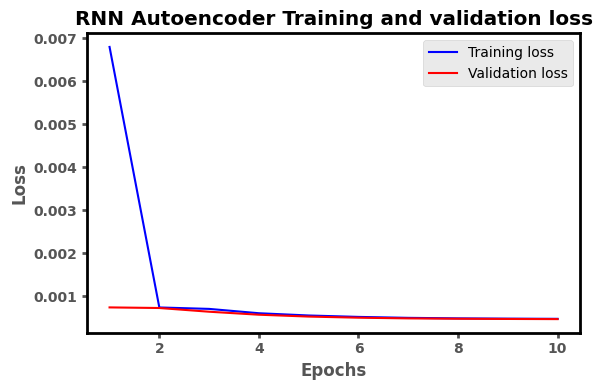

In [27]:
#plot the autoencoder performance
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(autenHistory, save_path=None):
    loss = autenHistory.history['loss']
    val_loss = autenHistory.history['val_loss']
    x = range(1, len(loss) + 1)

    fig, (ax2) = plt.subplots(1,figsize=(6, 4))
    
    # Plot training and validation loss
    ax2.plot(x, loss, 'b', label='Training loss')
    ax2.plot(x, val_loss, 'r', label='Validation loss')
    ax2.set_title('RNN Autoencoder Training and validation loss', fontweight='bold')
    ax2.set_xlabel('Epochs', fontweight='bold')
    ax2.set_ylabel('Loss', fontweight='bold')
    ax2.legend()
    
    # Make border lines bold and internal space white for both subplots
    for ax in [ax2]:
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
        ax.set_facecolor('white')

        # Make axis tick labels bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontweight('bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

plot_history (autenHistory, save_path="autoencoder_training_validation_loss.png")

# Build RNN (LSTM) Classifier and test the model with 10 epoch

In [28]:
#Extract Encodings
encoder_model = Model(encoder_inputs, encoder_states)
X_train_encoded_states = encoder_model.predict(X_train_tfidf)
X_val_encoded_states = encoder_model.predict(X_val_tfidf)
X_test_encoded_states = encoder_model.predict(X_test_tfidf)

# Use only the hidden state for classification
X_train_encoded = X_train_encoded_states[1]  # state_h
X_val_encoded = X_val_encoded_states[1]      # state_h
X_test_encoded = X_test_encoded_states[1]    # state_h

# Reshape encoded data to have a sequence dimension
X_train_encoded = np.reshape(X_train_encoded, (X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_val_encoded = np.reshape(X_val_encoded, (X_val_encoded.shape[0], 1, X_val_encoded.shape[1]))
X_test_encoded = np.reshape(X_test_encoded, (X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

print(X_train_encoded.shape)  # Should be (num_samples, 1, 64)
print(X_val_encoded.shape)    # Should be (num_samples, 1, 64)
print(X_test_encoded.shape)   # Should be (num_samples, 1, 64)

(24996, 1, 64)
(6250, 1, 64)
(7812, 1, 64)


In [45]:
ops.reset_default_graph() 
tf.compat.v1.disable_eager_execution()
# Build the LSTM Classifier
classifier = Sequential(name="SQLI_Attack_Detecter")
classifier.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=None, recurrent_dropout=0.0), input_shape=(1, 64)))
classifier.add(Bidirectional(LSTM(64, kernel_regularizer=None, recurrent_dropout=0.0)))
classifier.add(BatchNormalization())
classifier.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.00001)

classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Set up a log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

# Train the LSTM Classifier
history = classifier.fit(X_train_encoded, y_train,
                         epochs=100,
                         verbose=True,
                         validation_data=(X_val_encoded, y_val),
                         batch_size=64,
                         callbacks=[early_stopping, tensorboard_callback])

# Save the model
classifier.save('model.h5')

# Create summary writers for train and test evaluations
train_eval_writer = tf.summary.create_file_writer(log_dir + '/train_evaluation')
test_eval_writer = tf.summary.create_file_writer(log_dir + '/test_evaluation')

# Evaluate the Classifier and log the metrics
train_loss, train_accuracy = classifier.evaluate(X_train_encoded, y_train, verbose=True)
print(f"SQLI_Attack_Detection_Model Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

with train_eval_writer.as_default():
    tf.summary.scalar('loss', train_loss, step=0)
    tf.summary.scalar('accuracy', train_accuracy, step=0)
    train_eval_writer.flush()  # Ensure that the data is written to disk

test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test, verbose=True)
print(f"SQLI_Attack_Detection_Model Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Log test evaluation metrics to TensorBoard
with test_eval_writer.as_default():
    tf.summary.scalar('loss', test_loss, step=0)
    tf.summary.scalar('accuracy', test_accuracy, step=0)
    test_eval_writer.flush()  # Ensure that the data is written to disk

Model: "SQLI_Attack_Detecter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 256)           197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 362,625
Trainable params: 362,369
Non-trainable params: 256
______________________________________

## deep learning RNN (biderectional LSTM) performance analysis 

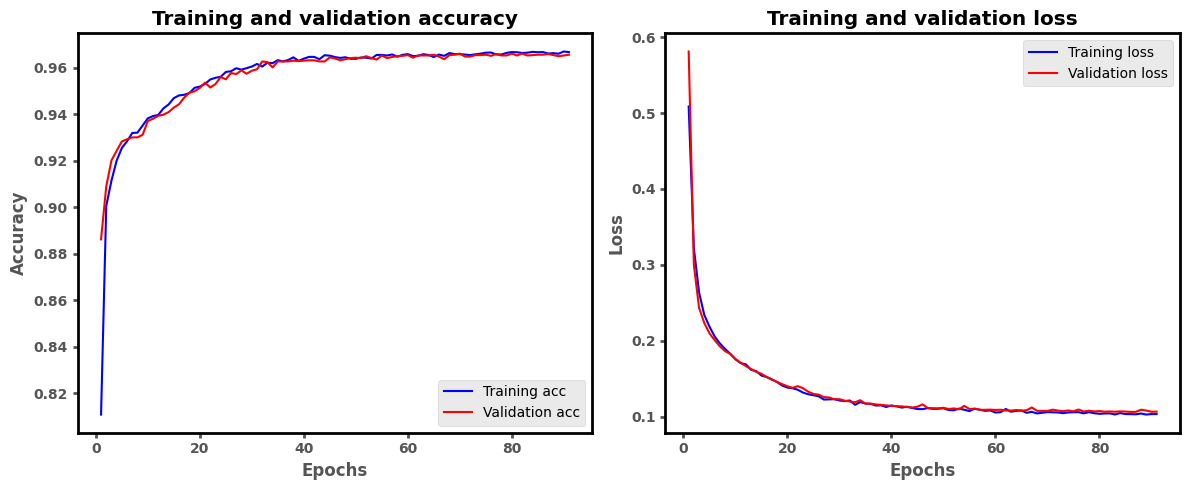

In [46]:
# plot RNN classifier perforance
plt.style.use('ggplot')

def plot_history(history, save_path=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training and validation accuracy
    ax1.plot(x, acc, 'b', label='Training acc')
    ax1.plot(x, val_acc, 'r', label='Validation acc')
    ax1.set_title('Training and validation accuracy', fontweight='bold')
    ax1.set_xlabel('Epochs', fontweight='bold')
    ax1.set_ylabel('Accuracy', fontweight='bold')
    ax1.legend()
    
    # Plot training and validation loss
    ax2.plot(x, loss, 'b', label='Training loss')
    ax2.plot(x, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss', fontweight='bold')
    ax2.set_xlabel('Epochs', fontweight='bold')
    ax2.set_ylabel('Loss', fontweight='bold')
    ax2.legend()
    
    # Make border lines bold and internal space white for both subplots
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)
        ax.set_facecolor('white')

        # Make axis tick labels bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontweight('bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

plot_history (history, save_path="LSTM_training_validation_loss_and_accuracy.png")

SQLI_Attack_Detection_Model Training Loss: 0.0932 SQLI_Attack_Detection_Model Training Accuracy: 0.9681
SQLI_Attack_Detection_Model Training Precision: 0.9970
SQLI_Attack_Detection_Model Training Recall (Sensitivity): 0.9389
SQLI_Attack_Detection_Model Training F1 Score: 0.9671
SQLI_Attack_Detection_Model Training ROC AUC: 0.9940
SQLI_Attack_Detection_Model Training specificity: 0.9972


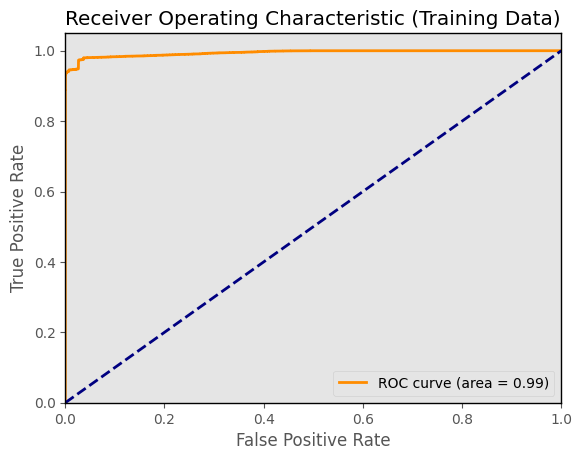

SQLI_Attack_Detection_Model Test Loss: 0.1045 SQLI_Attack_Detection_Model Test Accuracy: 0.9642
SQLI_Attack_Detection_Model Test Precision: 0.9962
SQLI_Attack_Detection_Model Test Recall (Sensitivity): 0.9326
SQLI_Attack_Detection_Model Test F1 Score: 0.9634
SQLI_Attack_Detection_Model Test ROC AUC: 0.9880
SQLI_Attack_Detection_Model Test specificity: 0.9964


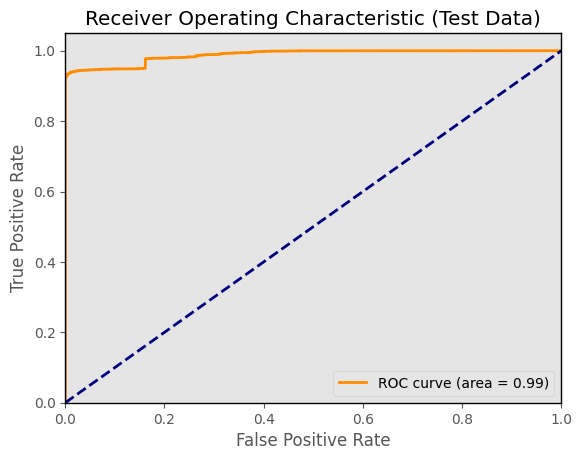

In [86]:
# Evaluate the classifier on training data
train_loss, train_accuracy = classifier.evaluate(X_train_encoded, y_train, verbose=True)
print("SQLI_Attack_Detection_Model Training Loss: {:.4f}".format(train_loss), 
      "SQLI_Attack_Detection_Model Training Accuracy: {:.4f}".format(train_accuracy))

# Get predictions for training data
y_train_pred_prob = classifier.predict(X_train_encoded)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

confusion = confusion_matrix(y_train, y_train_pred)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


# Calculate additional metrics for training data
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred_prob)
train_roc_auc = auc(train_fpr, train_tpr)
specificity = TN / (TN + FP)

print("SQLI_Attack_Detection_Model Training Precision: {:.4f}".format(train_precision))
print("SQLI_Attack_Detection_Model Training Recall (Sensitivity): {:.4f}".format(train_recall))
print("SQLI_Attack_Detection_Model Training F1 Score: {:.4f}".format(train_f1))
print("SQLI_Attack_Detection_Model Training ROC AUC: {:.4f}".format(train_roc_auc))
print("SQLI_Attack_Detection_Model Training specificity: {:.4f}".format(specificity))

plt.figure()
ax = plt.gca()  # Get current axis
for spine in ax.spines.values():
    spine.set_linewidth(1)  # Set border (spine) line width
    spine.set_edgecolor('black')  # Set border (spine) line color
plt.plot(train_fpr, train_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Training Data)')
plt.legend(loc="lower right")
save_path='Receiver Operating Characteristic (Training Data).png'
plt.savefig(save_path)
plt.show()

# Evaluate the classifier on test data
test_loss, test_accuracy = classifier.evaluate(X_test_encoded, y_test, verbose=True)
print("SQLI_Attack_Detection_Model Test Loss: {:.4f}".format(test_loss), 
      "SQLI_Attack_Detection_Model Test Accuracy: {:.4f}".format(test_accuracy))

# Get predictions for test data
y_test_pred_prob = classifier.predict(X_test_encoded)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)
confusiontest = confusion_matrix(y_test, y_test_pred)

TP = confusiontest[1, 1]
TN = confusiontest[0, 0]
FP = confusiontest[0, 1]
FN = confusiontest[1, 0]

# Calculate additional metrics for test data
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_prob)
test_roc_auc = auc(test_fpr, test_tpr)
specificity = TN / (TN + FP)


print("SQLI_Attack_Detection_Model Test Precision: {:.4f}".format(test_precision))
print("SQLI_Attack_Detection_Model Test Recall (Sensitivity): {:.4f}".format(test_recall))
print("SQLI_Attack_Detection_Model Test F1 Score: {:.4f}".format(test_f1))
print("SQLI_Attack_Detection_Model Test ROC AUC: {:.4f}".format(test_roc_auc))
print("SQLI_Attack_Detection_Model Test specificity: {:.4f}".format(specificity))

# Plot ROC curve for test data
plt.figure()
ax = plt.gca()  # Get current axis
for spine in ax.spines.values():
    spine.set_linewidth(1)  # Set border (spine) line width
    spine.set_edgecolor('black')  # Set border (spine) line color
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Data)')
plt.legend(loc="lower right")
save_path='Receiver Operating Characteristic (Test Data).png'
plt.savefig(save_path)
plt.show()

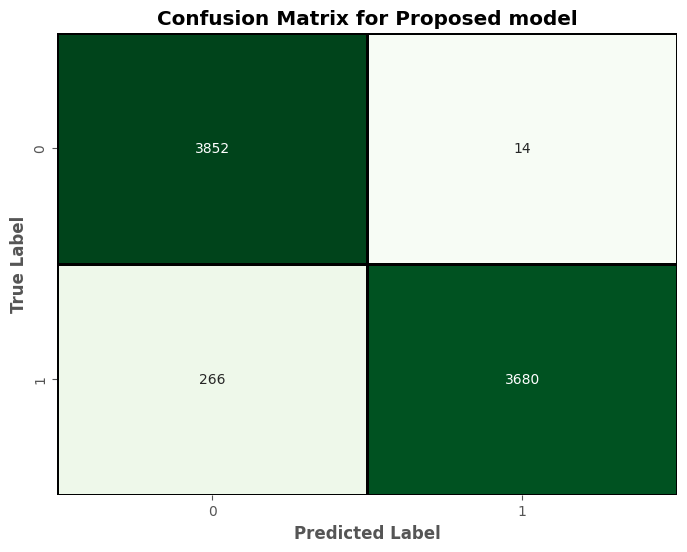

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(y_trues, y_preds, labels, model_names):
    for y_true, y_pred, model_name in zip(y_trues, y_preds, model_names):
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        plt.figure(figsize=(8, 6))

        # Create the heatmap with bold cell lines by increasing `linewidths`
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                         xticklabels=labels, yticklabels=labels, 
                         cbar=False, linewidths=2, linecolor='black')

        # Set the title and labels with bold fonts
        plt.title(f'Confusion Matrix for {model_name}', fontweight='bold')
        plt.xlabel('Predicted Label', fontweight='bold')
        plt.ylabel('True Label', fontweight='bold')

        # Make the matrix border (spines) bold
        for spine in ax.spines.values():
            spine.set_linewidth(3)  # Set border line width
            spine.set_edgecolor('black')  # Set border line color

        # Save the plot and show it
        save_path = f'Confusion matrix for {model_name}.png'
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()

# Example usage
y_trues = [y_test]  
y_preds = [y_test_pred]  
model_names = ['Proposed model']
plot_confusion_matrices(y_trues, y_preds, labels=[0, 1], model_names=model_names)

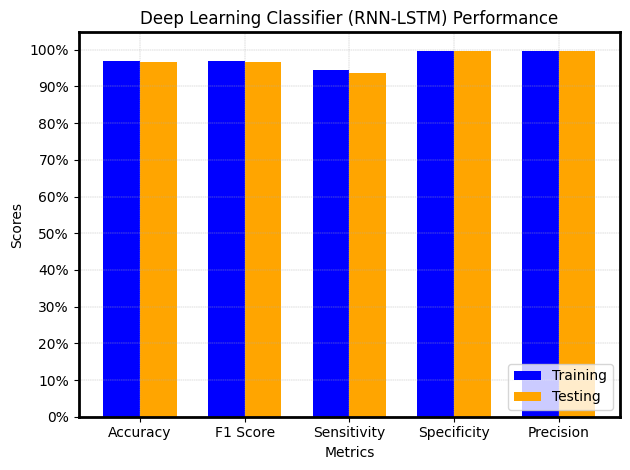

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

# Data to plot
metrics = ['Accuracy', 'F1 Score', 'Sensitivity', 'Specificity', 'Precision']
training_scores = [97.06, 96.98, 94.37, 99.75, 99.74]  # values for training
testing_scores = [96.70, 96.63, 93.69, 99.77, 99.76]  # values for testing

# Convert percentages to fractions
training_scores = [x/100 for x in training_scores]
testing_scores = [x/100 for x in testing_scores]

# Bar width
bar_width = 0.35

# X locations for the groups
index = np.arange(len(metrics))

# Create bar plots
fig, ax = plt.subplots()
bars1 = ax.bar(index, training_scores, bar_width, label='Training', color='blue')
bars2 = ax.bar(index + bar_width, testing_scores, bar_width, label='Testing', color='orange')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Deep Learning Classifier (RNN-LSTM) Performance')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=1)

# Format y-axis to display percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Set the y-axis step to 10%
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.1))

# Show grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.30)

# Add border around the plot
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Adjust layout to make room for the labels
plt.tight_layout()
plt.savefig('deep_learning_(RNN-LSTM)_performance.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


## make prediction using different machine learning classifiers after deep learning unsupervised (Autoencoder) feature extraction process

## SQL Injection Detection by Machine learning

In [27]:
df=pd.read_csv('Modified_SQL_Dataset.csv')
# Drop duplicated rows and keep only unique ones
df= df.drop_duplicates()
X = df['Query']
y = df['Label']

In [28]:
#data vectorization
import nltk
nltk.download('stopwords')

vectorizer = CountVectorizer(min_df = 2, max_df = 0.8, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(X.values.astype('U')).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


(24725, 6592)
(24725,)
(6182, 6592)
(6182,)


In [25]:
# GaussianNB model
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)

print(f"Accuracy of Naive Bayes on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Naive Bayes on test set : {f1_score(y_pred, y_test)}")


confusion = confusion_matrix(y_test, y_pred)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

sensitivity = TP / float(FN + TP)
print("sensitivity=",sensitivity)

specificity = TN / (TN + FP)
print("specificity=",specificity)

Precision = TP / float(TP + FP)
#Recall = TP / float(TP + FN)
#F1 = 2*((Precision*Recall)/(Precision+Recall))
print ("Precision=",Precision)

Accuracy of Naive Bayes on test set : 0.8186670980265286
F1 Score of Naive Bayes on test set : 0.8039867109634552
sensitivity= 0.9892426850258176
specificity= 0.7159149818558839
Precision= 0.6771723122238587


In [27]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 217.9 kB/s eta 0:07:38
   ---------------------------------------- 0.0/99.8 MB 245.8 kB/s eta 0:06:46
   ---------------------------------------- 0.1/99.8 MB 328.2 kB/s eta 0:05:04
   ---------------------------------------- 0.1/99.8 MB 420.8 kB/s eta 0:03:57
   ---------------------------------------- 0.2/99.8 MB 655.4 kB/s eta 0:02:32
   ---------------------------------------- 0.3/99.8 MB 948.8 kB/s eta 0:01:45
   ---------------------------------------- 0.4/99.8 MB 1.2 MB/s eta 0:01:26
   ---------------------------------------- 0.6/99.8 MB 1.4 MB/s eta 0:01:11
   ---------------

In [28]:
# XGBClassifier model
from xgboost import XGBClassifier
xg_clf = XGBClassifier()
xg_clf.fit(X_train, y_train)
y_pred = xg_clf.predict(X_test)

print(f"Accuracy of XGBClassifier on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of XGBClassifier on test set : {f1_score(y_pred, y_test)}")


confusion = confusion_matrix(y_test, y_pred)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

sensitivity = TP / float(FN + TP)
print("sensitivity=",sensitivity)

specificity = TN / (TN + FP)
print("specificity=",specificity)

Precision = TP / float(TP + FP)
#Recall = TP / float(TP + FN)
#F1 = 2*((Precision*Recall)/(Precision+Recall))
print ("Precision=",Precision)

Accuracy of XGBClassifier on test set : 0.9396635393076674
F1 Score of XGBClassifier on test set : 0.9146257724879835
sensitivity= 0.8597246127366609
specificity= 0.987817522032141
Precision= 0.9770171149144254


In [29]:
# Local learner modeling (SVM)
from sklearn import model_selection
from sklearn.svm import SVC
svm_clf=SVC(probability=True, kernel='rbf')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

print(f"Accuracy of Support vector machine on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Support vector machine on test set : {f1_score(y_pred, y_test)}")


confusion = confusion_matrix(y_test, y_pred)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

sensitivity = TP / float(FN + TP)
print("sensitivity=",sensitivity)

specificity = TN / (TN + FP)
print("specificity=",specificity)

Precision = TP / float(TP + FP)
#Recall = TP / float(TP + FN)
#F1 = 2*((Precision*Recall)/(Precision+Recall))
print ("Precision=",Precision)

Accuracy of Support vector machine on test set : 0.9388547395664834
F1 Score of Support vector machine on test set : 0.9142468239564429
sensitivity= 0.867039586919105
specificity= 0.9821150855365475
Precision= 0.966890595009597


In [68]:
# KNeighborsClassifier model
from sklearn.neighbors import KNeighborsClassifier
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

print(f"Accuracy of KNeighborsClassifier on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of KNeighborsClassifier on test set : {f1_score(y_pred, y_test)}")

confusion = confusion_matrix(y_test, y_pred)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

sensitivity = TP / float(FN + TP)
print("sensitivity=",sensitivity)

specificity = TN / (TN + FP)
print("specificity=",specificity)

Precision = TP / float(TP + FP)
#Recall = TP / float(TP + FN)
#F1 = 2*((Precision*Recall)/(Precision+Recall))
print ("Precision=",Precision)

Accuracy of KNeighborsClassifier on test set : 0.7516641065028162
F1 Score of KNeighborsClassifier on test set : 0.8021619416683663
sensitivity= 0.996705524581855
specificity= 0.5015519917227108
Precision= 0.671160409556314


In [69]:
# ExtraTreesClassifier (ETC) model
from sklearn.ensemble import ExtraTreesClassifier
exr_clf=ExtraTreesClassifier()
exr_clf.fit(X_train, y_train)
y_pred = exr_clf.predict(X_test)

print(f"Accuracy of ExtraTreesClassifier on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of ExtraTreesClassifier on test set : {f1_score(y_pred, y_test)}")

confusion = confusion_matrix(y_test, y_pred)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

sensitivity = TP / float(FN + TP)
print("sensitivity=",sensitivity)

specificity = TN / (TN + FP)
print("specificity=",specificity)

Precision = TP / float(TP + FP)
#Recall = TP / float(TP + FN)
#F1 = 2*((Precision*Recall)/(Precision+Recall))
print ("Precision=",Precision)

Accuracy of ExtraTreesClassifier on test set : 0.848310291858679
F1 Score of ExtraTreesClassifier on test set : 0.8691041643654037
sensitivity= 0.9969589457678661
specificity= 0.6965856182100362
Precision= 0.7703152535735265


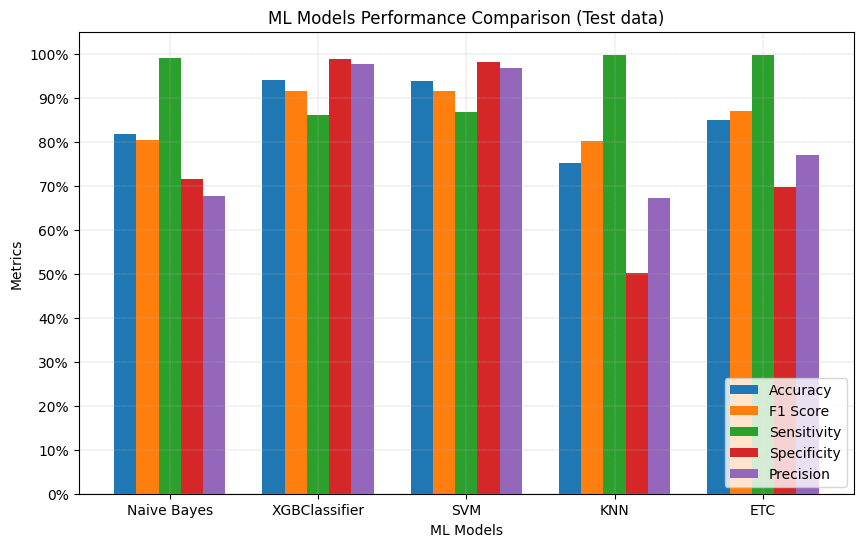

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

# Data
models = ['Naive Bayes', 'XGBClassifier', 'SVM', 'KNN', 'ETC']
accuracy = [81.86, 93.96, 93.88, 75.16, 84.83]
f1_score = [80.39, 91.46, 91.42, 80.21, 86.91]
sensitivity = [98.92, 85.97, 86.70, 99.67, 99.69]
specificity = [71.59, 98.78, 98.21, 50.15, 69.65]
precision = [67.71, 97.70, 96.68, 67.11, 77.03]

# Convert percentages to fractions
accuracy = [x/100 for x in accuracy]
f1_score = [x/100 for x in f1_score]
sensitivity = [x/100 for x in sensitivity]
specificity = [x/100 for x in specificity]
precision = [x/100 for x in precision]

# Bar width
bar_width = 0.15
index = np.arange(len(models))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + bar_width, f1_score, bar_width, label='F1 Score')
plt.bar(index + 2*bar_width, sensitivity, bar_width, label='Sensitivity')
plt.bar(index + 3*bar_width, specificity, bar_width, label='Specificity')
plt.bar(index + 4*bar_width, precision, bar_width, label='Precision')

# Format y-axis to display percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# Set the y-axis step to 10%
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
plt.grid(True, which='both', linestyle='--', linewidth=0.30)

# Labels and title
plt.xlabel('ML Models')
plt.ylabel('Metrics')
plt.title('ML Models Performance Comparison (Test data)')
plt.xticks(index + 2*bar_width, models)
plt.ylim(0, 1.05)  # Limits of y-axis, similar to the 0% to 120% in the provided image
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=1)
plt.savefig('ML models performance comparison.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()


## comparison of deep learning (DL) and machine learning(ML) 

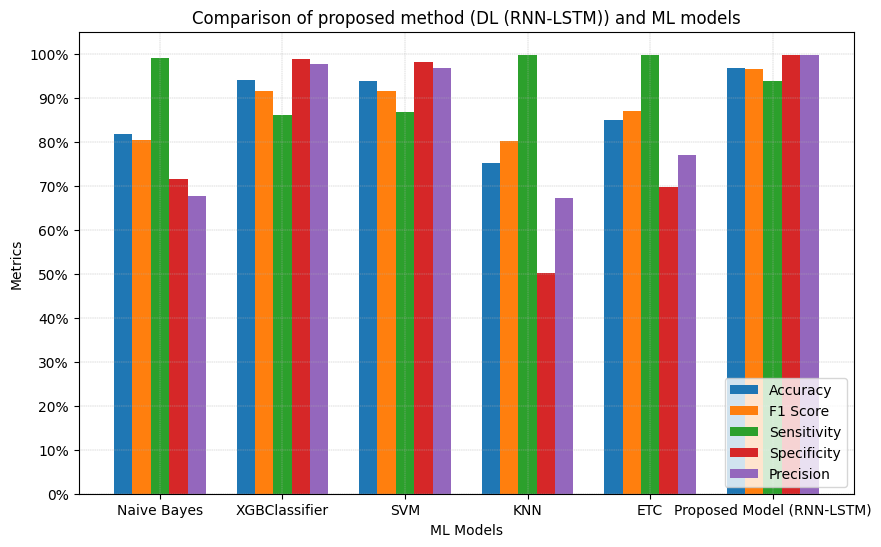

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

# Data
models = ['Naive Bayes', 'XGBClassifier', 'SVM', 'KNN', 'ETC', 'Proposed Model (RNN-LSTM)']
accuracy = [81.86, 93.96, 93.88, 75.16, 84.83, 96.70]
f1_score = [80.39, 91.46, 91.42, 80.21, 86.91, 96.63]
sensitivity = [98.92, 85.97, 86.70, 99.67, 99.69, 93.69]
specificity = [71.59, 98.78, 98.21, 50.15, 69.65, 99.77]
precision = [67.71, 97.70, 96.68, 67.11, 77.03, 99.76]


# Convert percentages to fractions
accuracy = [x/100 for x in accuracy]
f1_score = [x/100 for x in f1_score]
sensitivity = [x/100 for x in sensitivity]
specificity = [x/100 for x in specificity]
precision = [x/100 for x in precision]

# Bar width
bar_width = 0.15
index = np.arange(len(models))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + bar_width, f1_score, bar_width, label='F1 Score')
plt.bar(index + 2*bar_width, sensitivity, bar_width, label='Sensitivity')
plt.bar(index + 3*bar_width, specificity, bar_width, label='Specificity')
plt.bar(index + 4*bar_width, precision, bar_width, label='Precision')

# Format y-axis to display percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# Set the y-axis step to 10%
plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(0.1))
plt.grid(True, which='both', linestyle='--', linewidth=0.30)

# Labels and title
plt.xlabel('ML Models')
plt.ylabel('Metrics')
plt.title('Comparison of proposed method (DL (RNN-LSTM)) and ML models')
plt.xticks(index + 2*bar_width, models)
plt.ylim(0, 1.05)  # Limits of y-axis, similar to the 0% to 120% in the provided image
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=1)
plt.savefig('ML and DL comparison.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()
